In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
from io_grb_pop import root_dir
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs
import cosmology as cs
import f90_functions as f90f

# General imports
import yaml
import logging
import corner
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.style.use('paper')
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']

15:03:28.258 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
15:03:28.259 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
15:03:28.260 [DEBUG] File paths :
    'config'          : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'           : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum'         : /Users/palmerio/Science_projects/GRB_population_mo

15:05:54.106 [DEBUG] Starting calculations of photon fluences...
15:05:54.137 [DEBUG] Done in 0.031 s
15:05:54.138 [DEBUG] Starting calculations of energy fluences...
15:05:54.175 [DEBUG] Done in 0.037 s
15:05:54.176 [DEBUG] Starting calculations of detection probability...
15:05:54.177 [DEBUG] Stern sample:
15:05:54.188 [DEBUG] Done in 0.010 s
15:05:54.189 [DEBUG] EpGBM sample:
15:05:54.200 [DEBUG] Done in 0.011 s
15:05:54.201 [DEBUG] eBAT6 sample:
15:05:54.210 [DEBUG] Done in 0.009 s
15:05:54.210 [DEBUG] Swift sample:
15:05:54.222 [DEBUG] Done in 0.011 s
15:05:54.222 [DEBUG] ECLAIRs sample:
15:06:45.221 [DEBUG] Done in 50.998 s
15:06:45.221 [DEBUG] SHOALS sample:
15:06:45.235 [DEBUG] Done in 0.014 s
15:06:45.236 [DEBUG] GBM_sample sample:
15:06:45.246 [DEBUG] Done in 0.010 s
15:06:45.247 [DEBUG] BATSE_5B_sample sample:
15:06:45.259 [DEBUG] Done in 0.011 s
Sample size :1313
Sample size :82
[INFO] in compute_CDF_bounds_by_MC: initializing...
[INFO] in compute_CDF_bounds_by_MC: starting

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


[INFO] in compute_CDF_bounds_by_MC: plotting...


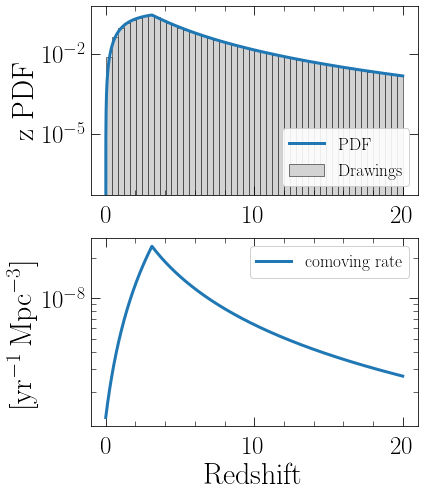

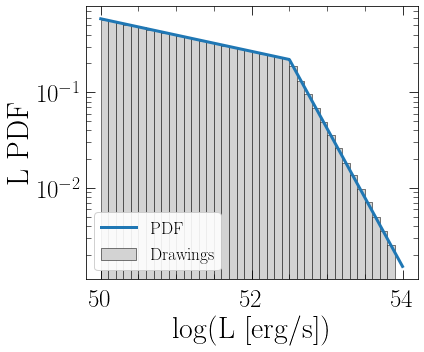

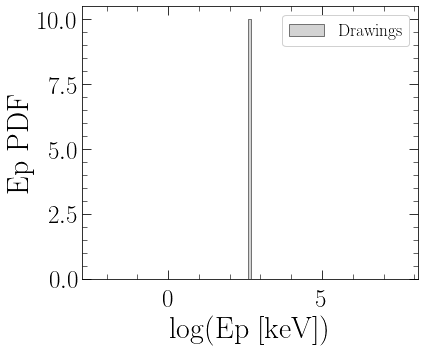

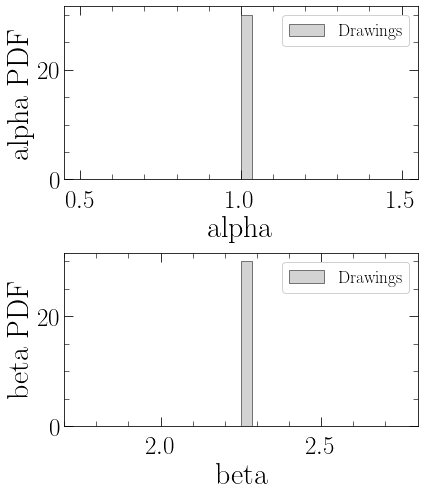

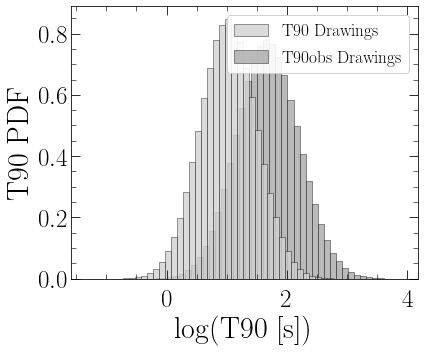

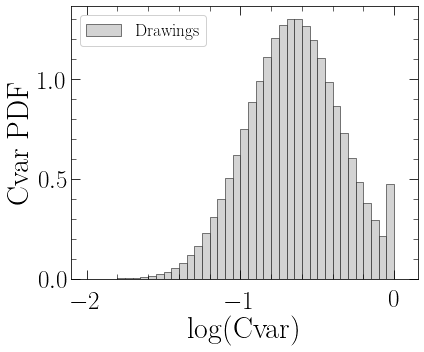

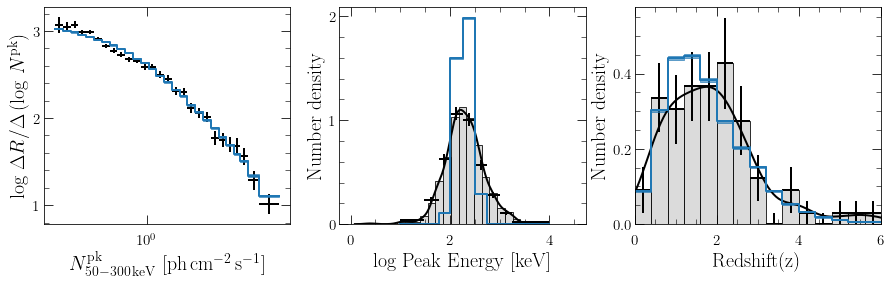

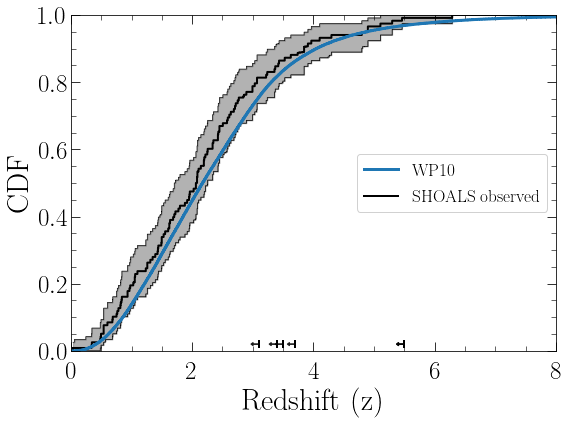

In [5]:
# Wanderman & Piran 2010
WP10 = True
if WP10:
    lab = 'WP10'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different (h=0.7 instead of 0.71)
    cosmo = cs.create_cosmology(OmegaM=0.27, OmegaL=0.73, h=0.7, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':52.5,
                                  'slopeL':1.17,
                                  'slopeH':2.44,
                                  'logLmin':50,
                                  'logLmax':54,
                                  'k_evol':0}
    params['redshift_distribution']={'model':'BPL',
                                    'zm':3.11,
                                    'a':2.07,
                                    'b':-1.36}
    params['peak_energy_distribution']={'model':'Fixed',
                                    'Ep0':511.}
    params['spectral_shape']={'model':'FBand',
                                    'alpha':1,
                                    'beta':2.25}

    incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
    Nb_GRBs=int(1e6)
    gp = GRBPopulation(Nb_GRBs=Nb_GRBs)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
    gp.normalize_GRB_population()

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab)

    # fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color='C0',
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
    # fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')


15:06:51.044 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
15:06:51.045 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
15:06:51.045 [DEBUG] File paths :
    'config'          : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'           : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum'         : /Users/palmerio/Science_projects/GRB_population_mo

15:09:19.588 [DEBUG] Starting calculations of photon fluences...
15:09:19.622 [DEBUG] Done in 0.033 s
15:09:19.622 [DEBUG] Starting calculations of energy fluences...
15:09:19.668 [DEBUG] Done in 0.045 s
15:09:19.668 [DEBUG] Starting calculations of detection probability...
15:09:19.669 [DEBUG] Stern sample:
15:09:19.686 [DEBUG] Done in 0.016 s
15:09:19.687 [DEBUG] EpGBM sample:
15:09:19.709 [DEBUG] Done in 0.021 s
15:09:19.710 [DEBUG] eBAT6 sample:
15:09:19.728 [DEBUG] Done in 0.018 s
15:09:19.730 [DEBUG] Swift sample:
15:09:19.746 [DEBUG] Done in 0.014 s
15:09:19.747 [DEBUG] ECLAIRs sample:
15:10:15.430 [DEBUG] Done in 55.682 s
15:10:15.430 [DEBUG] SHOALS sample:
15:10:15.446 [DEBUG] Done in 0.015 s
15:10:15.447 [DEBUG] GBM_sample sample:
15:10:15.467 [DEBUG] Done in 0.019 s
15:10:15.468 [DEBUG] BATSE_5B_sample sample:
15:10:15.479 [DEBUG] Done in 0.011 s
Sample size :1313
Sample size :82
[INFO] in compute_CDF_bounds_by_MC: initializing...
[INFO] in compute_CDF_bounds_by_MC: starting

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


[INFO] in compute_CDF_bounds_by_MC: starting bootstraps...
[INFO] in compute_CDF_bounds_by_MC: computing CDF...
[INFO] in compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:117: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


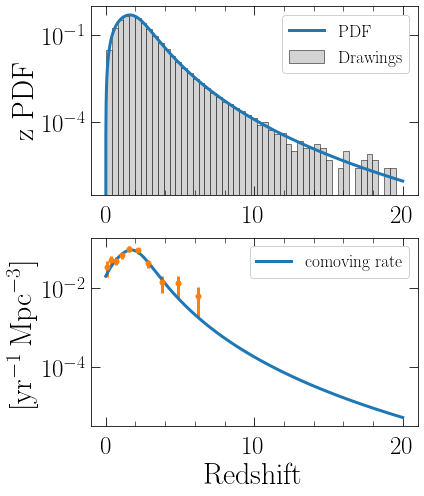

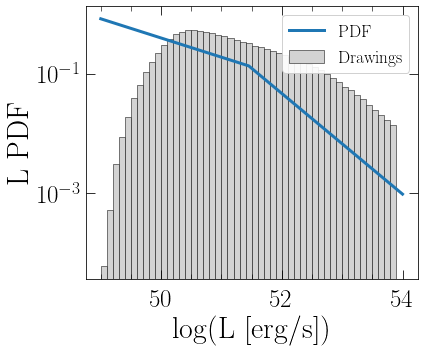

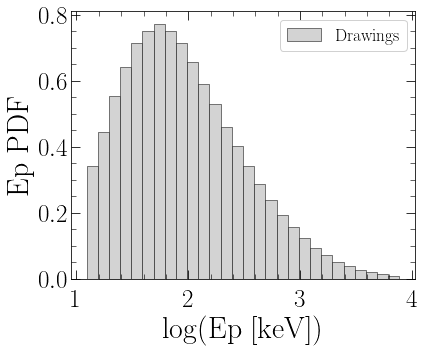

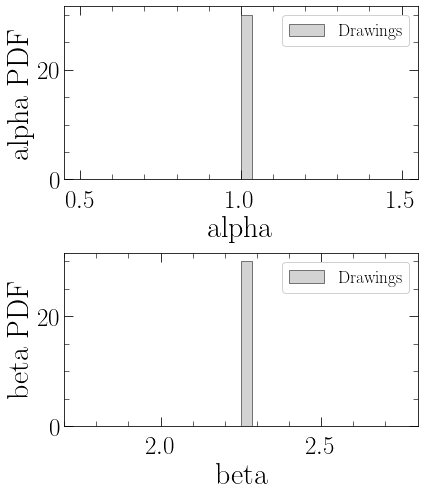

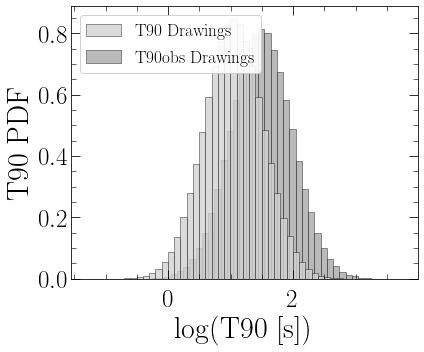

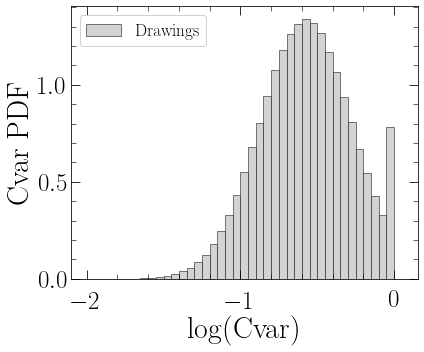

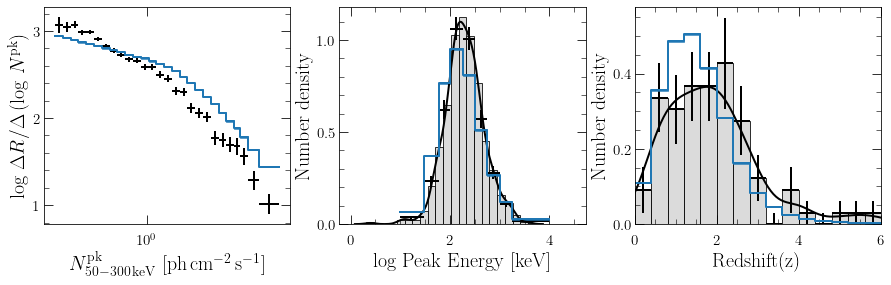

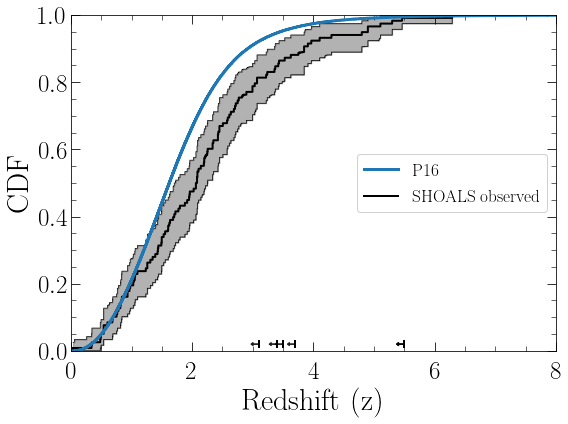

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


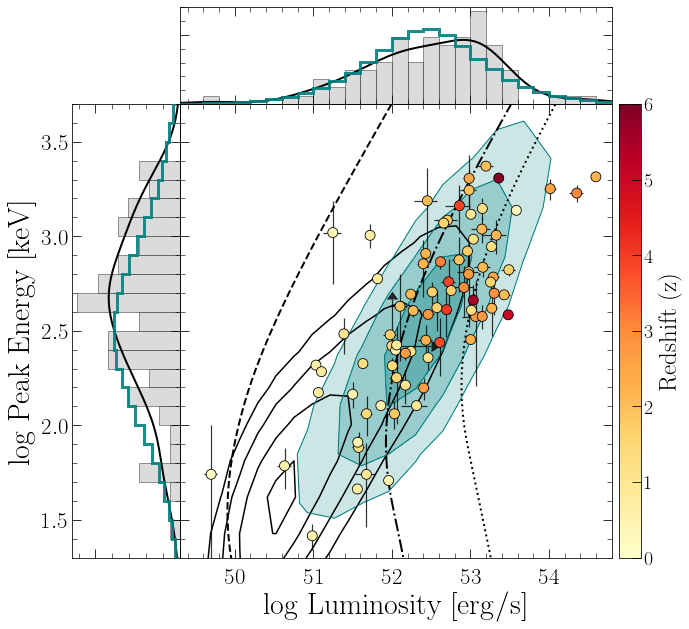

In [6]:
# Pescalli 2016
P16 = True
if P16:
    lab = 'P16'
    color = 'teal'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.7, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':51.45,
                                  'slopeL':1.32,
                                  'slopeH':1.84,
                                  'logLmin':49,
                                  'logLmax':54,
                                  'k_evol':2.5}
    params['redshift_distribution']={'model':'P16'}
    params['peak_energy_distribution']={'model':'A',
                                        'Ep0':309.,
                                        'alpha_amati':0.54,
                                        'sigmaEp':0.28}
    params['spectral_shape']={'model':'FBand',
                                    'alpha':1,
                                    'beta':2.25}

    incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
    Nb_GRBs=int(1e6)
    gp = GRBPopulation(Nb_GRBs=Nb_GRBs)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
    gp.normalize_GRB_population()

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab)

#     fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color='C0',
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
#     fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')

    plt.style.use('paper')
    df = gp.properties
    cond = df['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   plot_left_hist=False, plot_top_hist=False,
                   hist2d_kwargs={'color':'k', 'bins':30,
                                  'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':False})
    pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':color,
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': color,
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':color, 
                                  'contour_kwargs':{'linewidths':1},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
#     fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{lab}.pdf', bbox_inches='tight')


15:10:23.643 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
15:10:23.644 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
15:10:23.645 [DEBUG] File paths :
    'config'          : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'           : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum'         : /Users/palmerio/Science_projects/GRB_population_mo

15:12:49.326 [DEBUG] Starting calculations of photon fluences...
15:12:49.365 [DEBUG] Done in 0.038 s
15:12:49.365 [DEBUG] Starting calculations of energy fluences...
15:12:49.407 [DEBUG] Done in 0.041 s
15:12:49.408 [DEBUG] Starting calculations of detection probability...
15:12:49.409 [DEBUG] Stern sample:
15:12:49.420 [DEBUG] Done in 0.011 s
15:12:49.421 [DEBUG] EpGBM sample:
15:12:49.432 [DEBUG] Done in 0.011 s
15:12:49.433 [DEBUG] eBAT6 sample:
15:12:49.444 [DEBUG] Done in 0.011 s
15:12:49.445 [DEBUG] Swift sample:
15:12:49.454 [DEBUG] Done in 0.009 s
15:12:49.455 [DEBUG] ECLAIRs sample:
15:13:40.811 [DEBUG] Done in 51.356 s
15:13:40.811 [DEBUG] SHOALS sample:
15:13:40.819 [DEBUG] Done in 0.007 s
15:13:40.819 [DEBUG] GBM_sample sample:
15:13:40.830 [DEBUG] Done in 0.010 s
15:13:40.830 [DEBUG] BATSE_5B_sample sample:
15:13:40.839 [DEBUG] Done in 0.008 s
Sample size :1313
Sample size :82
[INFO] in compute_CDF_bounds_by_MC: initializing...
[INFO] in compute_CDF_bounds_by_MC: starting

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


[INFO] in compute_CDF_bounds_by_MC: plotting...


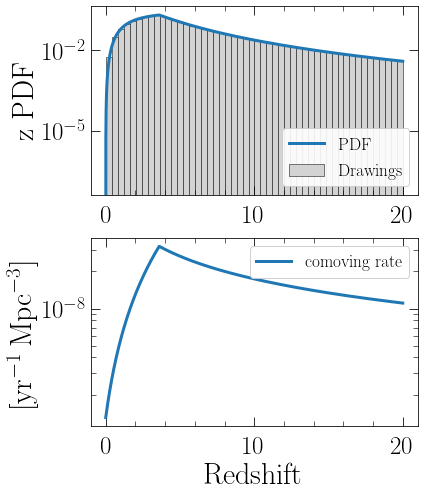

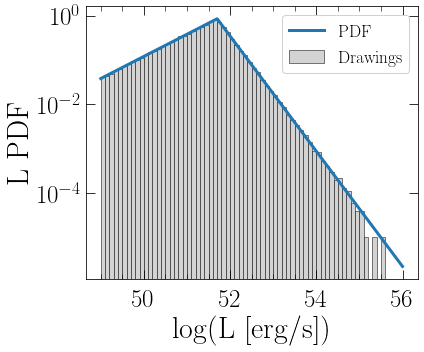

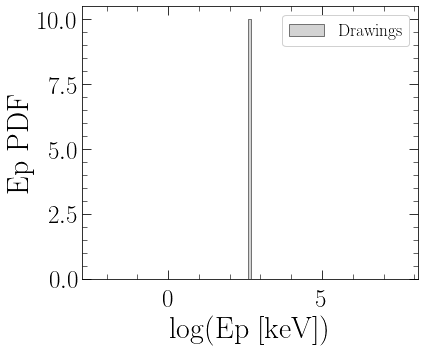

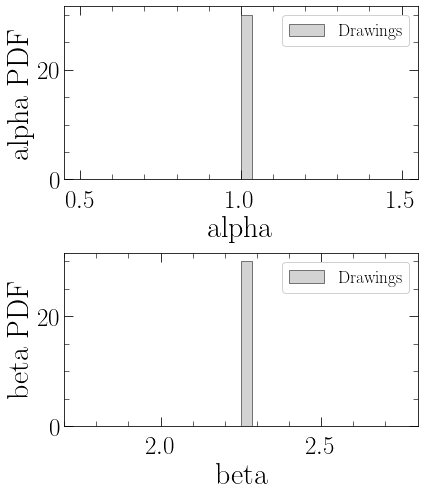

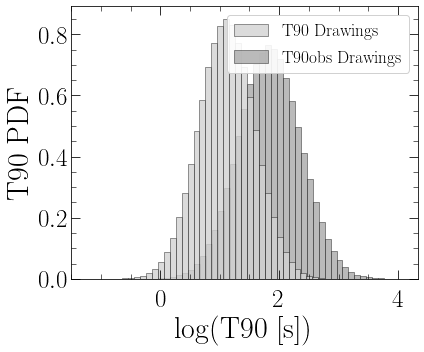

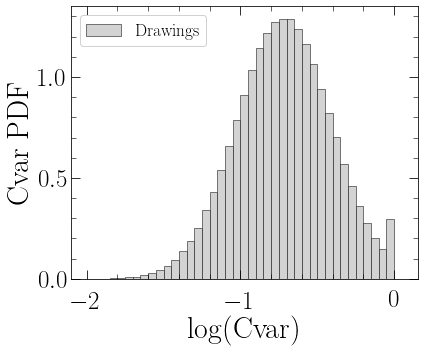

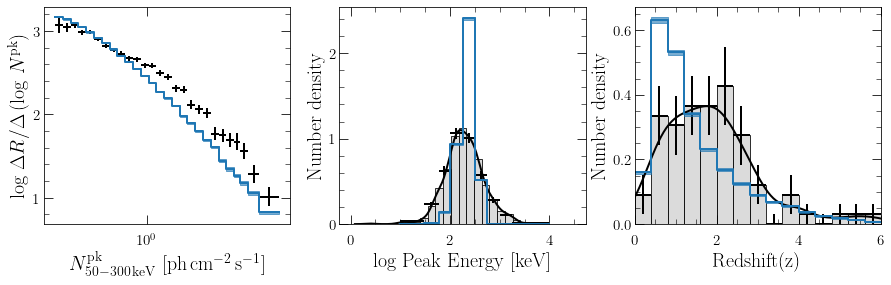

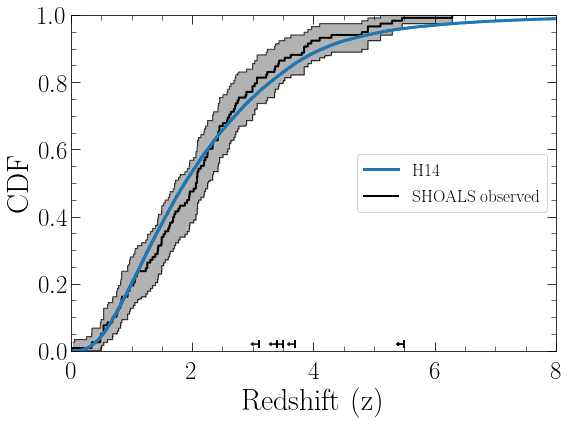

In [7]:
# Howell 2014
H14 = True
if H14:
    lab = 'H14'
    color = 'crimson'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different
    cosmo = cs.create_cosmology(OmegaM=0.32, OmegaL=0.68, h=0.67, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':51.7,
                                  'slopeL':0.5,
                                  'slopeH':2.3,
                                  'logLmin':49,
                                  'logLmax':56,
                                  'k_evol':0.0}
    params['redshift_distribution']={'model':'BPL',
                                     'zm':3.6,
                                     'a':2.1,
                                     'b':-0.7}
    params['peak_energy_distribution']={'model':'Fixed',
                                        'Ep0':511.}
    params['spectral_shape']={'model':'FBand',
                                    'alpha':1,
                                    'beta':2.25}

    incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
    Nb_GRBs=int(1e6)
    gp = GRBPopulation(Nb_GRBs=Nb_GRBs)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
    gp.normalize_GRB_population()

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab)

#     fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color='C0',
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
#     fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')

#     plt.style.use('paper')
#     df = gp.properties
#     cond = df['pht_pflx_BAT'] >= 2.6
#     fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
#                    mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
#                    plot_left_hist=False, plot_top_hist=False,
#                    hist2d_kwargs={'color':'k', 'bins':30,
#                                   'contour_kwargs':{'linewidths':1.5, 'zorder':2},
#                                   'plot_datapoints':False, 
#                                   'plot_density':False, 
#                                   'plot_contours':True,
#                                   'fill_contours':False})
#     pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
#                    mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
#                    left_hist_kwargs={'label': None,
#                                      'bins':np.linspace(1,4,31),
#                                      'edgecolor':color,
#                                      'linewidth':3,
#                                      'zorder':5,
#                                      'alpha':0.9,
#                                      'histtype':'step'},
#                    top_hist_kwargs={'label': None,
#                                     'bins': np.linspace(49,55,31),
#                                     'edgecolor': color,
#                                     'linewidth':3,
#                                     'zorder':5,
#                                     'alpha':0.9,
#                                     'histtype':'step'},
#                    hist2d_kwargs={'color':color, 
#                                   'contour_kwargs':{'linewidths':1},
#                                   'plot_datapoints':False, 
#                                   'plot_density':False, 
#                                   'plot_contours':True,
#                                   'fill_contours':True})
#     pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
#     fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{lab}.pdf', bbox_inches='tight')


Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 65.0
17:14:15.207 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:14:15.210 [INFO] Including instruments: ['BATSE', 'BAT']
17:14:15.212 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:14:16.064 [INFO] Starting calculations of peak photon fluxes...
17:14:30.357 [INFO] Starting calculations of peak photon fluxes...
17:14:54.760 [INFO] Starting calculations of peak energy fluxes...
17:15:18.098 [INFO] Starting calculations of detection probability...
Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


[INFO] in compute_CDF_bounds_by_MC: initializing...
[INFO] in compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
[INFO] in compute_CDF_bounds_by_MC: starting bootstraps...
[INFO] in compute_CDF_bounds_by_MC: computing CDF...
[INFO] in compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:117: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


17:15:23.099 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:15:23.100 [INFO] Including instruments: ['BATSE', 'BAT']
17:15:23.101 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:15:23.835 [INFO] Starting calculations of peak photon fluxes...
17:15:35.757 [INFO] Starting calculations of peak photon fluxes...
17:15:59.342 [INFO] Starting calculations of peak energy fluxes...
17:16:22.495 [INFO] Starting calculations of detection probability...
Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:117: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users

17:16:26.024 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:16:26.026 [INFO] Including instruments: ['BATSE', 'BAT']
17:16:26.027 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:16:26.793 [INFO] Starting calculations of peak photon fluxes...
17:16:39.357 [INFO] Starting calculations of peak photon fluxes...
17:17:03.847 [INFO] Starting calculations of peak energy fluxes...
17:17:27.219 [INFO] Starting calculations of detection probability...
Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Use

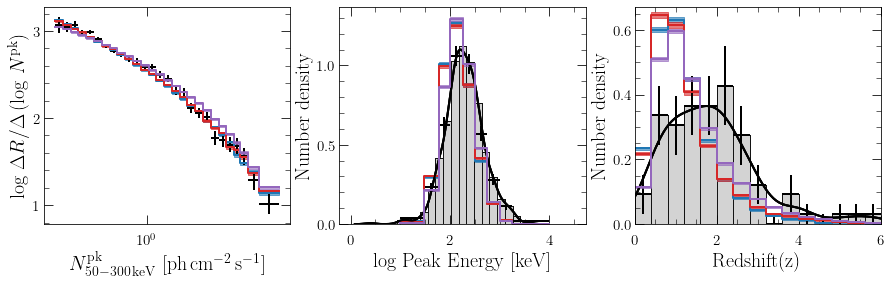

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


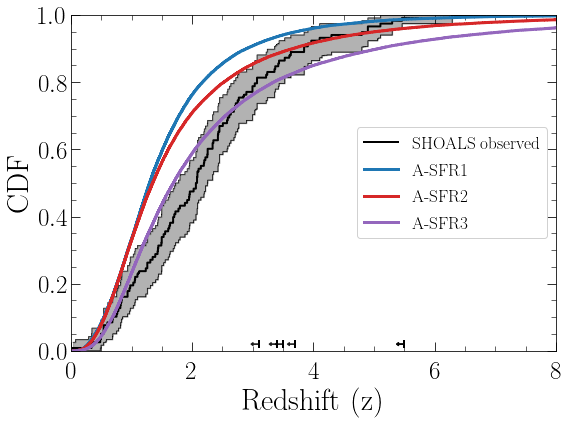

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


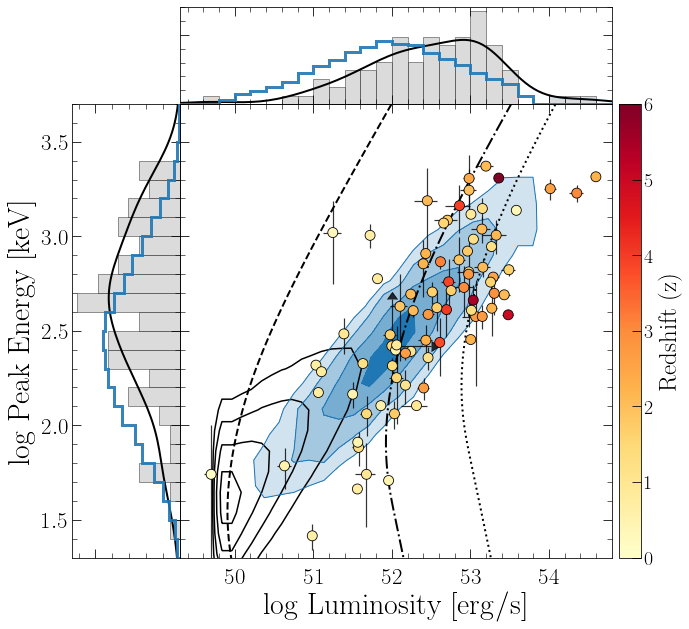

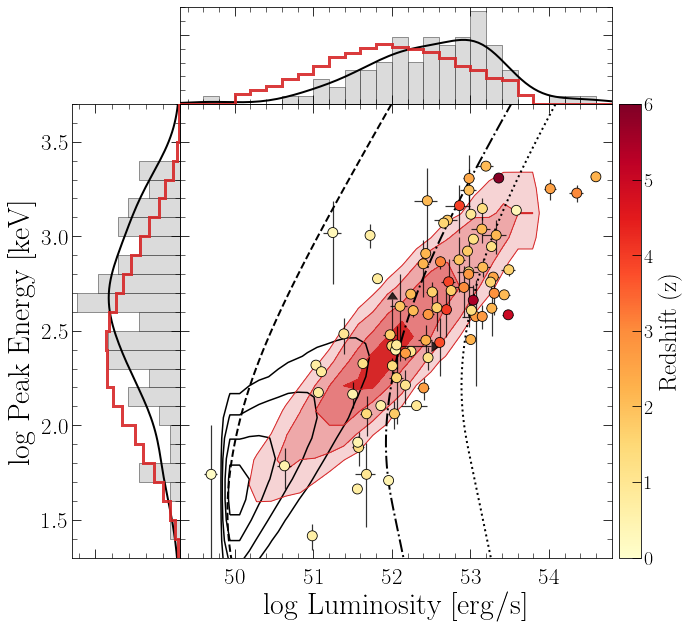

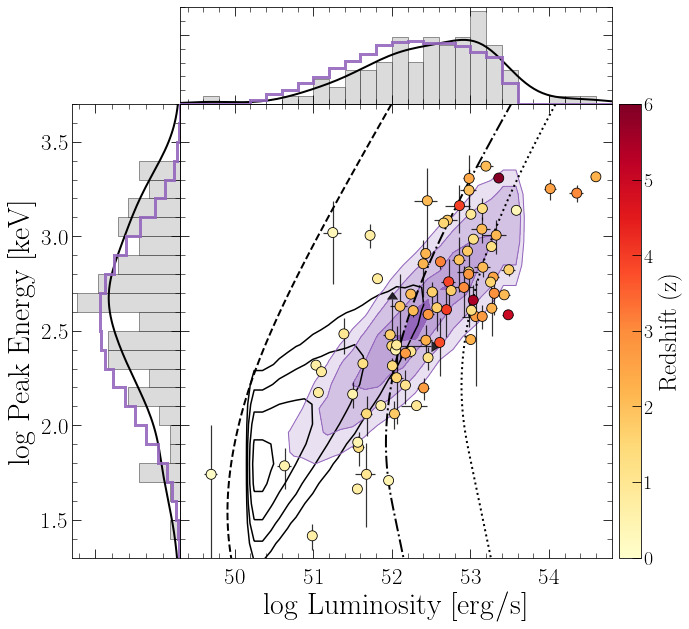

In [23]:
# Daigne 2006 for Amati-like relation
D06 = True
slopes = [1.70, 1.68, 1.54]
logLmins = [49.9, 50.0, 50.3]
logLmaxs = [53.7, 53.7, 53.5]
a_s = [0.320, 0.196, 0.175]
b_s = [3.30, 4.0, 3.67]
c_s = [3.52, 4.0, 3.58]
d_s = [23.6, 14.6, 12.6]
labels = ['A-SFR1', 'A-SFR2', 'A-SFR3']
colors = ['C0', 'C3', 'C4']
if D06:
    paths_to_dir, paths_to_files = io.generate_paths()
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.65, zmax=100)
    for i in range(len(slopes)):
        config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
        config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
        # Cosmology is slightly different
        params['luminosity_function']={'model':'EPL',
                                      'logLmin':logLmins[i],
                                      'logLmax':logLmaxs[i],
                                      'slope':slopes[i],
                                      'k_evol':0.0}
        params['redshift_distribution']={'model':'D06',
                                         'a':a_s[i],
                                         'b':b_s[i],
                                         'c':c_s[i],
                                         'd':d_s[i]}
        params['peak_energy_distribution']={'model':'A',
                                            'Ep0':380.,
                                            'alpha_amati':0.43,
                                            'sigmaEp':0.2}
        params['spectral_shape']={'model':'GBM_Band'}

        incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
                                                               samples=samples,
                                                               instruments=instruments,
                                                               obs_constraints=obs_constraints)
        ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                    ECLAIRs_config=instruments['ECLAIRs'])
        samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
        Nb_GRBs=int(1e6)
        gp = GRBPopulation(Nb_GRBs=Nb_GRBs)
        gp.draw_GRB_properties(cosmo, params)
        gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_photon_fluence(incl_instruments)
        gp.calc_energy_fluence(incl_instruments)
        gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
        gp.create_mock_constraints()
        gp.normalize_GRB_population()

        # Observational constraints
        plt.style.use('presentation')
        if i == 0:
            fig_cstr, axes_cstr = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
        pf.plot_intensity_constraint(axes_cstr[0], pop=gp, label=labels[i], color=colors[i])
        pf.plot_spectral_constraint(axes_cstr[1], pop=gp, label=labels[i], color=colors[i])
        pf.plot_redshift_constraint(axes_cstr[2], pop=gp, label=labels[i], color=colors[i])

        fig_cstr.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{labels[i]}.pdf', bbox_inches='tight')

        # SHOALS redshift distribution
        plt.style.use('paper')
        if i == 0:
            fig_SHOALS, ax_SHOALS = plt.subplots(figsize=(8,6))
            pf.plot_SHOALS_z_distr_with_bounds(ax_SHOALS)
        df = gp.properties
        pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                              key='z',
                              plot_obs=False,
                              cumul=True,
                              ax=ax_SHOALS,
                              mod_color=colors[i],
                              mod_label=labels[i], linewidth=3)

        fig_SHOALS.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{labels[i]}.pdf', bbox_inches='tight')

        plt.style.use('paper')
        df = gp.properties
        cond = df['pht_pflx_BAT'] >= 2.6
        fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       plot_left_hist=False, plot_top_hist=False,
                       hist2d_kwargs={'color':'k', 'bins':30, 
                                      'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':False})
        pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       left_hist_kwargs={'label': None,
                                         'bins':np.linspace(1,4,31),
                                         'edgecolor':colors[i],
                                         'linewidth':3,
                                         'zorder':5,
                                         'alpha':0.9,
                                         'histtype':'step'},
                       top_hist_kwargs={'label': None,
                                        'bins': np.linspace(49,55,31),
                                        'edgecolor': colors[i],
                                        'linewidth':3,
                                        'zorder':5,
                                        'alpha':0.9,
                                        'histtype':'step'},
                       hist2d_kwargs={'color':colors[i], 'label':labels[i],
                                      'contour_kwargs':{'linewidths':1},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':True})
        pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{labels[i]}.pdf', bbox_inches='tight')


Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 65.0
17:17:38.094 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:17:38.095 [INFO] Including instruments: ['BATSE', 'BAT']
17:17:38.097 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:17:38.922 [INFO] Starting calculations of peak photon fluxes...
17:17:51.648 [INFO] Starting calculations of peak photon fluxes...
17:18:16.053 [INFO] Starting calculations of peak energy fluxes...
17:18:41.228 [INFO] Starting calculations of detection probability...
Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


[INFO] in compute_CDF_bounds_by_MC: initializing...
[INFO] in compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
[INFO] in compute_CDF_bounds_by_MC: starting bootstraps...
[INFO] in compute_CDF_bounds_by_MC: computing CDF...
[INFO] in compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:117: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


17:18:46.948 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:18:46.949 [INFO] Including instruments: ['BATSE', 'BAT']
17:18:46.950 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:18:47.694 [INFO] Starting calculations of peak photon fluxes...
17:19:00.023 [INFO] Starting calculations of peak photon fluxes...
17:19:23.891 [INFO] Starting calculations of peak energy fluxes...
17:19:47.019 [INFO] Starting calculations of detection probability...
Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Use

17:19:50.761 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:19:50.762 [INFO] Including instruments: ['BATSE', 'BAT']
17:19:50.763 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:19:51.560 [INFO] Starting calculations of peak photon fluxes...
17:20:03.711 [INFO] Starting calculations of peak photon fluxes...
17:20:28.518 [INFO] Starting calculations of peak energy fluxes...
17:20:52.088 [INFO] Starting calculations of detection probability...
Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Use

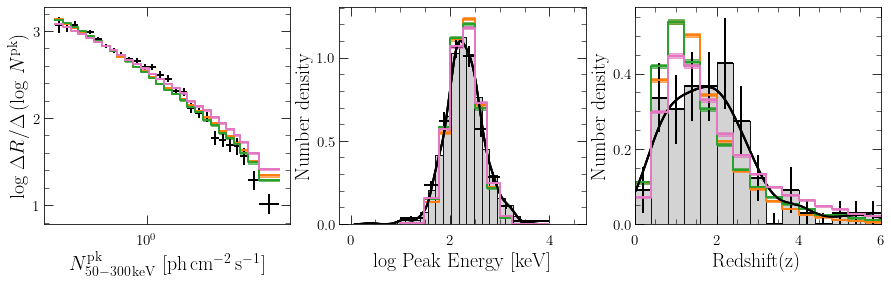

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


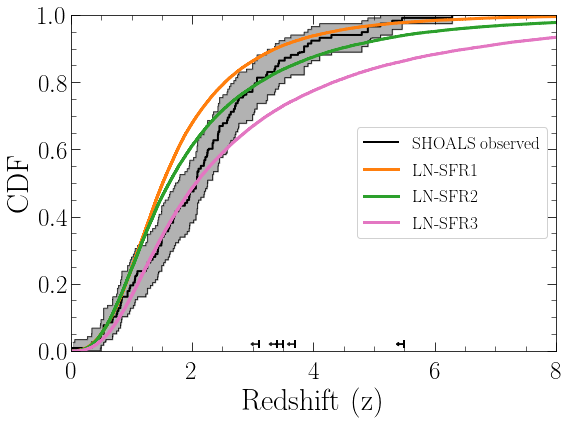

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


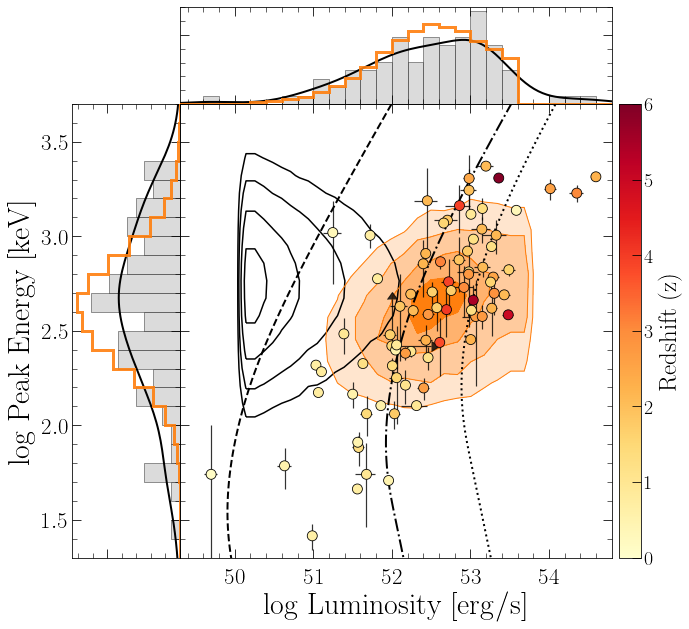

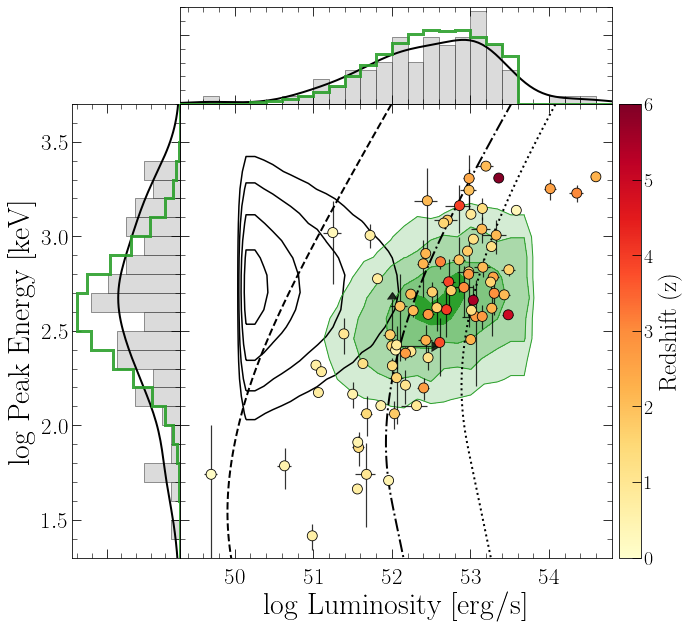

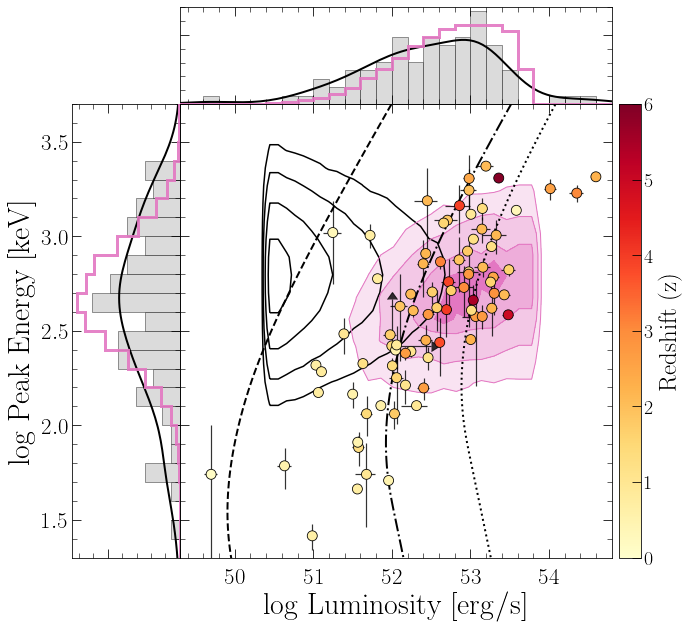

In [24]:
# Daigne 2006 for LogNormal relation
D06 = True
slopes = [1.62, 1.62, 1.52]
logLmins = [50.2, 50.2, 50.5]
logLmaxs = [53.6, 53.6, 53.7]
Ep0s = [10**2.74, 10**2.73, 10**2.79]
a_s = [0.320, 0.196, 0.175]
b_s = [3.30, 4.0, 3.67]
c_s = [3.52, 4.0, 3.58]
d_s = [23.6, 14.6, 12.6]
labels = ['LN-SFR1', 'LN-SFR2', 'LN-SFR3']
colors = ['C1', 'C2', 'C6']
if D06:
    paths_to_dir, paths_to_files = io.generate_paths()
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.65, zmax=100)
    for i in range(len(slopes)):
        config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
        config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
        # Cosmology is slightly different
        params['luminosity_function']={'model':'EPL',
                                      'logLmin':logLmins[i],
                                      'logLmax':logLmaxs[i],
                                      'slope':slopes[i],
                                      'k_evol':0.0}
        params['redshift_distribution']={'model':'D06',
                                         'a':a_s[i],
                                         'b':b_s[i],
                                         'c':c_s[i],
                                         'd':d_s[i]}
        params['peak_energy_distribution']={'model':'LN',
                                            'Ep0':Ep0s[i],
                                            'sigmaEp':0.3}
        params['spectral_shape']={'model':'GBM_Band'}

        incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
                                                               samples=samples,
                                                               instruments=instruments,
                                                               obs_constraints=obs_constraints)
        ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                    ECLAIRs_config=instruments['ECLAIRs'])
        samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
        Nb_GRBs=int(1e6)
        gp = GRBPopulation(Nb_GRBs=Nb_GRBs)
        gp.draw_GRB_properties(cosmo, params)
        gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_photon_fluence(incl_instruments)
        gp.calc_energy_fluence(incl_instruments)
        gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
        gp.create_mock_constraints()
        gp.normalize_GRB_population()

        # Observational constraints
        plt.style.use('presentation')
        if i == 0:
            fig_cstr, axes_cstr = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
        pf.plot_intensity_constraint(axes_cstr[0], pop=gp, label=labels[i], color=colors[i])
        pf.plot_spectral_constraint(axes_cstr[1], pop=gp, label=labels[i], color=colors[i])
        pf.plot_redshift_constraint(axes_cstr[2], pop=gp, label=labels[i], color=colors[i])

        fig_cstr.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{labels[i]}.pdf', bbox_inches='tight')

        # SHOALS redshift distribution
        plt.style.use('paper')
        if i == 0:
            fig_SHOALS, ax_SHOALS = plt.subplots(figsize=(8,6))
            pf.plot_SHOALS_z_distr_with_bounds(ax_SHOALS)
        df = gp.properties
        pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                              key='z',
                              plot_obs=False,
                              cumul=True,
                              ax=ax_SHOALS,
                              mod_color=colors[i],
                              mod_label=labels[i], linewidth=3)

        fig_SHOALS.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{labels[i]}.pdf', bbox_inches='tight')

        plt.style.use('paper')
        df = gp.properties
        cond = df['pht_pflx_BAT'] >= 2.6
        fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       plot_left_hist=False, plot_top_hist=False,
                       hist2d_kwargs={'color':'k', 'bins':30, 
                                      'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':False})
        pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       left_hist_kwargs={'label': None,
                                         'bins':np.linspace(1,4,31),
                                         'edgecolor':colors[i],
                                         'linewidth':3,
                                         'zorder':5,
                                         'alpha':0.9,
                                         'histtype':'step'},
                       top_hist_kwargs={'label': None,
                                        'bins': np.linspace(49,55,31),
                                        'edgecolor': colors[i],
                                        'linewidth':3,
                                        'zorder':5,
                                        'alpha':0.9,
                                        'histtype':'step'},
                       hist2d_kwargs={'color':colors[i], 'label':labels[i],
                                      'contour_kwargs':{'linewidths':1},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':True})
        pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{labels[i]}.pdf', bbox_inches='tight')
